In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pprint import pprint
from pymongo import MongoClient
from itertools import permutations, combinations

# Connect to MongoDB
client = MongoClient('mongodb://192.168.0.209', 27017)
db = client['capstone_1']
cards_coll = db['cards']
decks_coll = db['decks']
decklists_coll = db['deck_lists']
events_coll = db['events']

In [2]:
convert = {s: int for s in ['id_y', 'event_id']}
remove_keys = [
    'set',
    'setName',
    'artist',
    'number',
    'multiverseid',
    'imageUrl',
    'rulings',
    'foreignNames',
    'printings',
    'originalText',
    'originalType',
    'legalities',
    'variations',
    'watermark',
    'id'
]
remove_dict = {k: 0 for k in remove_keys}
remove_dict['_id'] = 0

events_df = pd.DataFrame(list(events_coll.find({}, {'_id':0, 'link':0})))
decklists_df = pd.DataFrame(list(decklists_coll.find({}, {'_id':0, 'link':0})))
cards_df = pd.DataFrame(list(cards_coll.find({}, remove_dict)))
decks_df = pd.DataFrame(list(decks_coll.find({}, {'_id':0, 'link':0, 'mainboard':0, 'sideboard':0})))
decks_df = events_df.merge(decks_df, left_on='id', right_on='event_id').astype(convert)
decks_df.set_index('id_y', inplace=True)
decks_df.rename_axis('id', inplace=True)
decks_df.drop('id_x', axis=1, inplace=True)
decks_df.drop([253183, 253184, 108514], axis=0, inplace=True)

strat_fix = {
    'Eldrazi Green': 'aggro',
    'Mannequin': 'control',
    'Elves!': 'aggro'
}

for rid in [207945, 108523, 108521, 108516]:
    title = decks_df.loc[207945]['title']
    decks_df.at[rid, 'strategy'] = strat_fix[title]
    decks_df.at[rid, 'archtype'] = title

In [3]:
def get_decklist_df(deck_id):
    decklist = decklists_df[decklists_df['deck_id'] == deck_id]
    cardlist = cards_df[cards_df['name'].isin(list(decklist['name']))]
    return cardlist.merge(decklist, on='name')

def rarity_count(deck_id):
    df = get_decklist_df(deck_id)
    deck_size = df['quantity'].sum()
    df = df[~df['type'].str.contains('Basic Land')]  # Remove basic lands
    output = df.groupby('rarity')['quantity'].sum().to_dict()
    output['size'] = deck_size
    output['deck_id'] = deck_id
    return output

I decided to go to a ratio of rare cards here because some decks in recent years have more than the minimum allowed # of cards.

In [4]:
rarity_df = pd.DataFrame([rarity_count(did) for did in decks_df.index]).fillna(0)
rarity_df['Rare'] = (rarity_df['Rare'] + rarity_df['Mythic']) / rarity_df['size']
rarity_df.drop(['Mythic', 'Uncommon', 'Common', 'size'], axis=1, inplace=True)
decks_df = decks_df.merge(rarity_df, left_index=True, right_on='deck_id').set_index('deck_id')

In [5]:
working_df = decks_df.drop(['name', 'date', 'level', 'meta', 'event_id', 'pilot', 'archtype'], axis=1)
print(working_df.info())
working_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 421716 to 253152
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      333 non-null    object 
 1   placement  333 non-null    object 
 2   strategy   333 non-null    object 
 3   Rare       333 non-null    float64
dtypes: float64(1), object(3)
memory usage: 13.0+ KB
None


,title,placement,strategy,Rare
deck_id,,,,
421716,Gruul Aggro,1,aggro,0.626667
421717,Abzan Aggro,2,aggro,0.706667
421719,Esper DOOM Yorion,3-4,control,0.610526
421718,Gruul Aggro,3-4,aggro,0.573333
421720,Dimir Mill,5-8,control,0.346667


Text(0.5, 0, 'Placement')

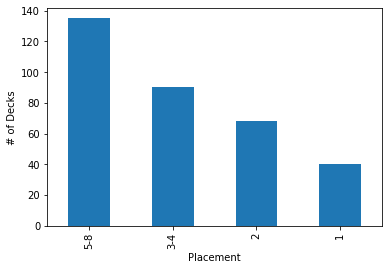

In [6]:
plot = working_df['placement'].value_counts().plot(kind='bar')
plot.set_ylabel('# of Decks')
plot.set_xlabel('Placement')

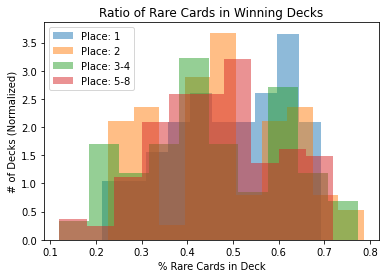

In [7]:
fig, axs = plt.subplots()
axs.set_title('Ratio of Rare Cards in Winning Decks')
axs.set_xlabel('% Rare Cards in Deck')
axs.set_ylabel('# of Decks (Normalized)')
for grouping in working_df['placement'].unique():
    q = working_df[working_df['placement'] == grouping]['Rare']
    axs.hist(q, alpha=0.5, density=True, label=f'Place: {grouping}', bins=10)

axs.legend()

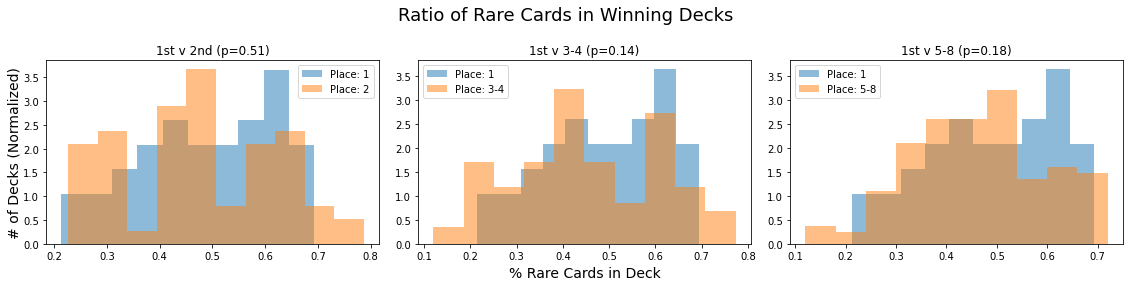

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(16,4))
fig.suptitle('Ratio of Rare Cards in Winning Decks', fontsize=18)
fig.add_subplot(111, frameon=False)
u = working_df['placement'].unique()[1:]
t = ['1st v 2nd (p=0.51)', '1st v 3-4 (p=0.14)', '1st v 5-8 (p=0.18)']
for i in range(3):
    q1 = working_df[working_df['placement'] == '1']['Rare']
    q2 = working_df[working_df['placement'] == u[i]]['Rare']
    axs[i].hist(q1, alpha=0.5, density=True, label=f'Place: {1}', bins=10)
    axs[i].hist(q2, alpha=0.5, density=True, label=f'Place: {u[i]}', bins=10)
    axs[i].set_title(t[i])
    axs[i].legend()

plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.xlabel('% Rare Cards in Deck', labelpad=22, fontsize=14)
plt.ylabel('# of Decks (Normalized)', labelpad=25, fontsize=14)
plt.savefig('1st_vs_all.png')

In [9]:
def tests(df, key):
    for combo in combinations(df['placement'].unique(), 2):
        c1 = df[df['placement'] == combo[0]][key]
        c2 = df[df['placement'] == combo[1]][key]
        yield combo, stats.ttest_ind(c1, c2, equal_var=False)

def print_results(results, a=0.05):
    alpha = a / len(results)
    for r in results:
        combo, result = r
        print(f'Place comparison: {combo[0]} vs {combo[1]}')
        if result[1] < alpha:
            print(f'  - PASS: {result[1]} < {alpha}')
        elif not result[1] < alpha:
            print(f'  - FAIL: {result[1]} !< {alpha}')
        print('')
    
print_results(tuple(tests(working_df, 'Rare')))

Place comparison: 1 vs 2
  - FAIL: 0.5141452310052546 !< 0.008333333333333333

Place comparison: 1 vs 3-4
  - FAIL: 0.14364596270792349 !< 0.008333333333333333

Place comparison: 1 vs 5-8
  - FAIL: 0.1788284025305446 !< 0.008333333333333333

Place comparison: 2 vs 3-4
  - FAIL: 0.3672236097430056 !< 0.008333333333333333

Place comparison: 2 vs 5-8
  - FAIL: 0.48191089091104167 !< 0.008333333333333333

Place comparison: 3-4 vs 5-8
  - FAIL: 0.7210885110209038 !< 0.008333333333333333



In [10]:
def cmc_count(deck_id):
    df = get_decklist_df(deck_id)
    deck_size = df['quantity'].sum()
    #df = df[~df['type'].str.contains('Basic Land')]  # Remove basic lands
    output = df['cmc'].mean()
    return output

In [11]:
decks_df['Mean CMC'] = decks_df.apply(lambda row: cmc_count(row.name), axis=1)
cmc_df = decks_df.drop(['name', 'date', 'level', 'meta', 'event_id', 'pilot', 'archtype', 'Rare'], axis=1)
cmc_df

,title,placement,strategy,Mean CMC
deck_id,,,,
421716,Gruul Aggro,1,aggro,2.666667
421717,Abzan Aggro,2,aggro,2.653846
421719,Esper DOOM Yorion,3-4,control,2.575758
421718,Gruul Aggro,3-4,aggro,2.793103
421720,Dimir Mill,5-8,control,1.838710
...,...,...,...,...
253185,Selesnya Aggro,5-8,aggro,1.892857
252617,Wug Control,1,control,1.945455
252616,RG Aggro,2,aggro,1.527778


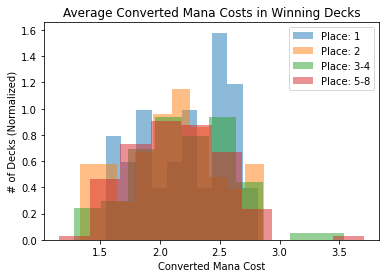

In [12]:
fig, axs = plt.subplots()
axs.set_title('Average Converted Mana Costs in Winning Decks')
axs.set_xlabel('Converted Mana Cost')
axs.set_ylabel('# of Decks (Normalized)')
for grouping in working_df['placement'].unique():
    q = cmc_df[working_df['placement'] == grouping]['Mean CMC']
    axs.hist(q, alpha=0.5, density=True, label=f'Place: {grouping}', bins=10)

axs.legend()

In [13]:
print_results(tuple(tests(cmc_df, 'Mean CMC')))

Place comparison: 1 vs 2
  - FAIL: 0.19939097253262092 !< 0.008333333333333333

Place comparison: 1 vs 3-4
  - FAIL: 0.7942196442339899 !< 0.008333333333333333

Place comparison: 1 vs 5-8
  - FAIL: 0.23080909662766463 !< 0.008333333333333333

Place comparison: 2 vs 3-4
  - FAIL: 0.2231408314615524 !< 0.008333333333333333

Place comparison: 2 vs 5-8
  - FAIL: 0.7680773901179766 !< 0.008333333333333333

Place comparison: 3-4 vs 5-8
  - FAIL: 0.2515430151798154 !< 0.008333333333333333



In [14]:
len(decks_df.index)

333